## Imports

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from Thomas_algo import ThomasAlgo
from Lagrange import LagrangeSym

In [43]:
func = np.sin
points = 13
xRange = np.linspace(0*np.pi, 2*np.pi, points)
yRange = func(xRange)

xSpace = np.linspace(0*np.pi, 2*np.pi, 101)
h = np.array( [xRange[i]-xRange[i-1] for i in range(1, points)] ) # Интервалы м/у точками 1...N

# Коэффициенты использующиеся в основных N-2 уравнениях
nu = [ h[j+1] / (h[j] + h[j+1]) for j in range(len(h)-1) ]
lm = [1 - nu_i for nu_i in nu]

In [ ]:
# Эта функци для замены сплайна. Она может менять функцию которую интерполирует сплайн, начало и конец, кол-во точек интерполяции.
# Также она пересчитывает важные коэффициенты, которые используются в формулах вычисления сплайна и его моментов
def init (_func, start, end, _points):
    global func, points, xRange, yRange, xSpace, h
    global nu, lm
    
    func = _func
    points = _points
    xRange = np.linspace(start, end, points)
    yRange = func(xRange)
    h = np.array( [xRange[i]-xRange[i-1] for i in range(1, points)] )
    
    xSpace = np.linspace(start, end, 101)
    nu = [ h[j+1] / (h[j] + h[j+1]) for j in range(len(h)-1) ]
    lm = [1 - nu_i for nu_i in nu]


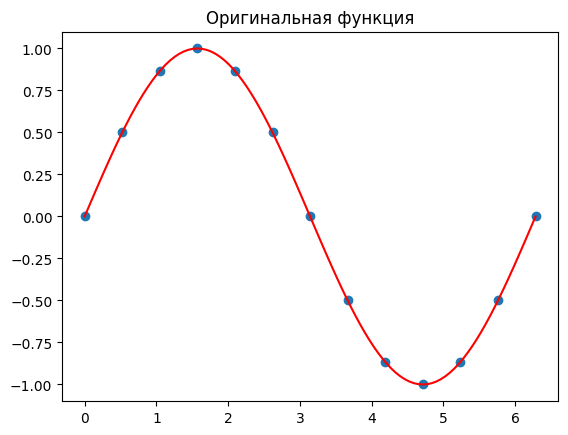

In [45]:
plt.title('Оригинальная функция')
plt.plot(xSpace, func(xSpace), color='red')
plt.scatter(xRange, yRange)
plt.show()

## Сплайны (Через моменты)

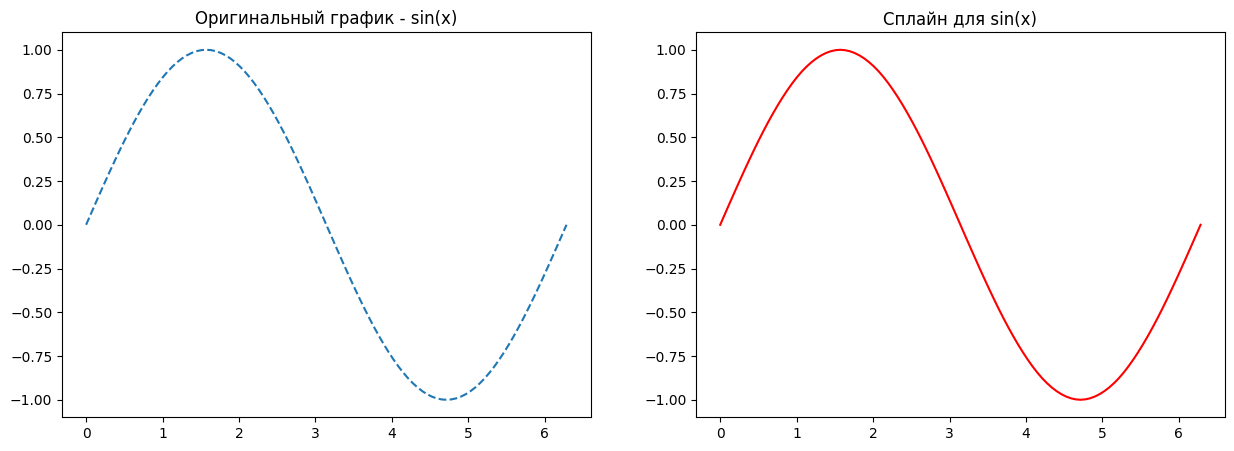

In [46]:
testMoments = -np.sin(xRange)

def Spline(x, Moments):
    i = np.clip(np.searchsorted(xRange, x)-1, 0, points-1) # Определяем в каком отрезке точка
    diff = x - xRange[i]

    a_i = Moments[i]
    b_i = (Moments[i+1] - Moments[i]) / h[i]
    c_i = (yRange[i+1] - yRange[i]) / h[i] - h[i]/6 * (2*Moments[i] + Moments[i+1])

    formula = yRange[i] + c_i * diff + a_i * diff ** 2 / 2 + b_i * diff ** 3 / 6
    return formula


fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Оригинальный график - sin(x)')
ax[1].set_title('Сплайн для sin(x)')
ax[0].plot(xSpace, func(xSpace), linestyle='--')
spline = Spline(xSpace, testMoments)
ax[1].plot(xSpace, spline, c='red')

### 1 Краевое условие:

In [47]:
def FindMoments1(A, B):
    MomentMat = np.zeros((points, points))
    b = np.ones_like(xRange)

    # Задаем правую часть
    b[0] = 6 / h[0] * ((yRange[1] - yRange[0]) / h[0] - A)

    i = np.arange(1, points-1)
    b[1:-1] = 6 / (h[i]+h[i-1]) * ((yRange[i+1] - yRange[i]) / h[i] - (yRange[i] - yRange[i-1]) / h[i-1])

    b[-1] = 6 / h[-1] * (B - (yRange[-1] - yRange[-2]) / h[-1])

    # Задаем матрицу (Левую часть)
    MomentMat[0][0] = 2
    MomentMat[0][1] = 1
    for i in range(1, points-1):
        MomentMat[i][i-1] = lm[i-1]
        MomentMat[i][i] = 2
        MomentMat[i][i+1] = nu[i-1]

    MomentMat[-1][-1] = 2
    MomentMat[-1][-2] = 1

    return ThomasAlgo(MomentMat, b)

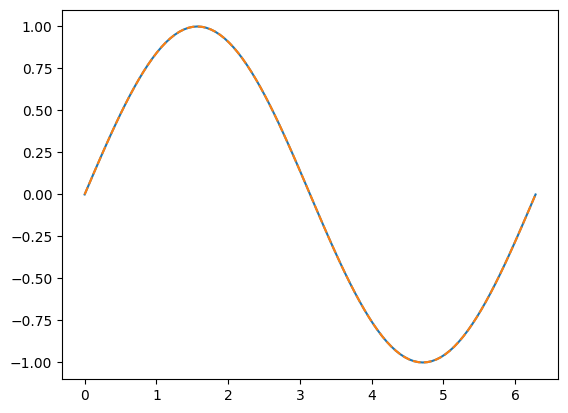

In [48]:
MyMoments = FindMoments1(np.cos(xRange[0]), np.cos(xRange[-1]))
spline = Spline(xSpace, MyMoments)

plt.plot(xSpace, spline)
plt.plot(xSpace, np.sin(xSpace), linestyle='--')

### 2 Краевое условие

In [49]:
def FindMoments2(M0, Mn):
    MomentMat = np.zeros((points-2, points-2))
    b = np.ones_like(xRange[:-2])

    # Задаем правую часть
    i = np.arange(1, points-1)
    b = 6 / (h[i]+h[i-1]) * ((yRange[i+1] - yRange[i]) / h[i] - (yRange[i] - yRange[i-1]) / h[i-1])
    b[0] -= lm[0]*M0
    b[-1] -= nu[-1]*Mn

    # Задаем матрицу (Левую часть)
    for i in range(points-2):
        if i != 0:
            MomentMat[i][i-1] = lm[i]
        MomentMat[i][i] = 2
        if i != points-3:
            MomentMat[i][i+1] = nu[i]

    return np.concatenate( [[M0], ThomasAlgo(MomentMat, b), [Mn]] )

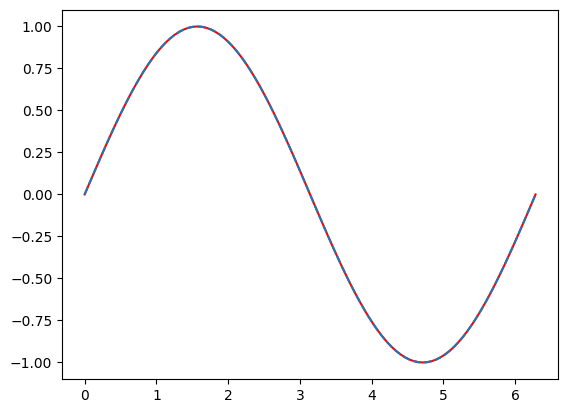

In [50]:
MyMoments1 = FindMoments1(np.cos(xRange[0]), np.cos(xRange[-1]))
MyMoments2 = FindMoments2(-np.sin(xRange[0]), -np.sin(xRange[-1]))
spline1 = Spline(xSpace, MyMoments1)
spline2 = Spline(xSpace, MyMoments2)
# print(MyMoments1)
plt.plot(xSpace, spline2, c='red')
# plt.plot(xSpace, spline1)
plt.plot(xSpace, np.sin(xSpace), linestyle='--')

### 3 Краевое условие

In [51]:
def FindMoments3():
    n = points

    Mat = np.zeros((n, n))
    B = np.zeros(n)

    i = np.arange(1, points-1)
    B[1:-1] = 6 / (h[i]+h[i-1]) * ((yRange[i+1] - yRange[i]) / h[i] - (yRange[i] - yRange[i-1]) / h[i-1])

    Mat[0,0] = 1
    Mat[0, -2] = -1
    Mat[-1, -1] = 1
    Mat[-1,1] = -1
    for i in range(1, n-1):
        Mat[i, i] = 2
        Mat[i, (i - 1) % n] = lm[i-1]
        Mat[i, (i + 1) % n] = nu[i-1]
        
    res = np.linalg.solve(Mat, B)
    return res

[ 6.98754996e-01 -6.98754996e-01 -8.35819381e-01 -1.03648658e+00
 -8.82403048e-01 -5.12420330e-01  5.94966650e-17  5.12420330e-01
  8.82403048e-01  1.03648658e+00  8.35819381e-01  6.98754996e-01
 -6.98754996e-01]


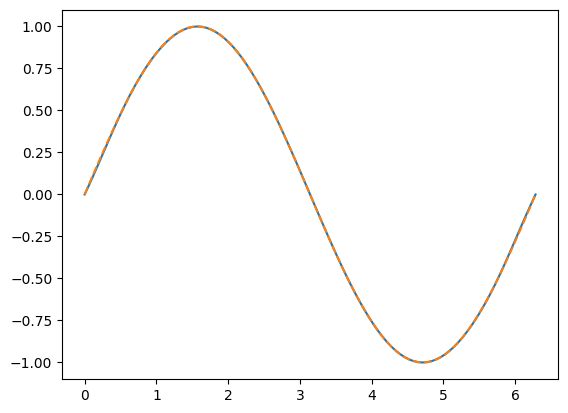

In [52]:
MyMoments3 = FindMoments3()
spline = Spline(xSpace, MyMoments3)
print(MyMoments3)
plt.plot(xSpace, spline)
plt.plot(xSpace, np.sin(xSpace), linestyle='--')

### 4 Краевое условие

In [53]:
gamma1 = h[0] / h[1]
gammaN = h[-1] / h[-2]

def FindMoments4():
    n = points-2
    Mat = np.zeros((n, n))
    
    b = np.zeros(n)
    i = np.arange(1, n+1)
    b = 6 / (h[i] + h[i-1])* ((yRange[i+1] - yRange[i])/h[i] - (yRange[i] - yRange[i-1])/h[i-1])

    Mat[0,0] = 2 + gamma1
    Mat[0,1] = (h[1] - h[0]) / h[1]
    # Mat[-1,-2] = (h[-3] - h[-2]) / h[-3]
    Mat[-1,-2] = (h[-2] - h[-1]) / h[-2]
    Mat[-1, -1] = 2 + gammaN
    for i in range(1, n-1):
        Mat[i, i-1] = lm[i-1]
        Mat[i, i] = 2
        Mat[i, i+1] = nu[i-1]

    answ = ThomasAlgo(Mat, b) # Нашли M_1... M_n-1 моменты
    M0 = answ[0] - gamma1*(answ[1] - answ[0])
    MN = answ[-1] + gammaN*(answ[-1] - answ[-2])

    return np.concatenate( [[M0], answ, [MN]] )

[-8.52542327e-02 -4.88680728e-01 -8.92107223e-01 -1.02140948e+00
 -8.86423608e-01 -5.11415190e-01 -2.49800181e-16  5.11415190e-01
  8.86423608e-01  1.02140948e+00  8.92107223e-01  4.88680728e-01
  8.52542327e-02]


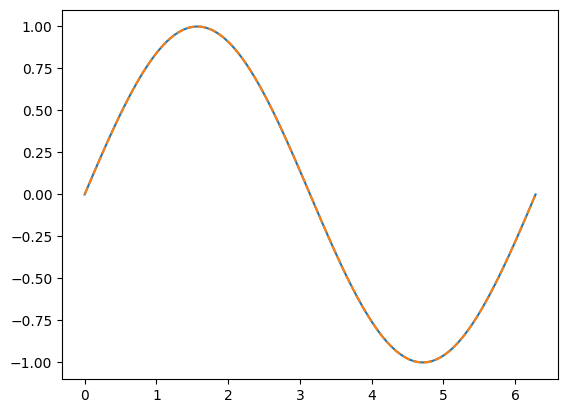

In [54]:
MyMoments4 = FindMoments4()
spline1 = Spline(xSpace, MyMoments4)
print(MyMoments4)
plt.plot(xSpace, spline1)
plt.plot(xSpace, np.sin(xSpace), linestyle='--')

## Дифференцирование и Интегрирование Сплайна построенного по моментам

In [ ]:
MyMoments = FindMoments4() # Вторые производные сплайна (по построению)

def SplineDerivative(x, Moments):
    idx = np.searchsorted(xRange, x) - 1
    idx = np.clip(idx, 0, points-2)
    
    hi = h[idx]
    dx = x - xRange[idx]
    Mi, Mip1 = Moments[idx], Moments[idx+1]
    yi, yip1 = yRange[idx], yRange[idx+1]

    term1 = (yip1 - yi) / hi
    term2 = (hi / 6) * (2*Mi + Mip1)
    term3 = Mi * dx
    term4 = ((Mip1 - Mi) / hi) * (dx**2 / 2)
    
    return term1 - term2 + term3 + term4

def SplineIntegral(i, Moments):
    hi = h[i]
    Mi, Mip1 = Moments[i], Moments[i+1]
    yi, yip1 = yRange[i], yRange[i+1]
    

    part1 = (hi / 2) * (yip1 + yi) 
    part2 = (Mip1 + Mi) * (hi**3 / 24)
    
    return part1 - part2

print('Производная sin в точке 3.14 равна', np.cos(3.14))
print('Производная сплайна в x - 3.14 равна', SplineDerivative(np.pi, MyMoments))

integral = sum( [SplineIntegral(i, MyMoments) for i in range(6)] )

print('Интеграл сплайна от 0 до pi (Ответ должен быть 2)', integral)

Производная sin в точке 3.14 равна -0.9999987317275395
Производная сплайна в x - 3.14 равна -0.999559053106579
Интеграл сплайна от 0 до pi (Ответ должен быть 2) 2.00006431771257


## Интересные махинации со сплайнами

### 1 Случай

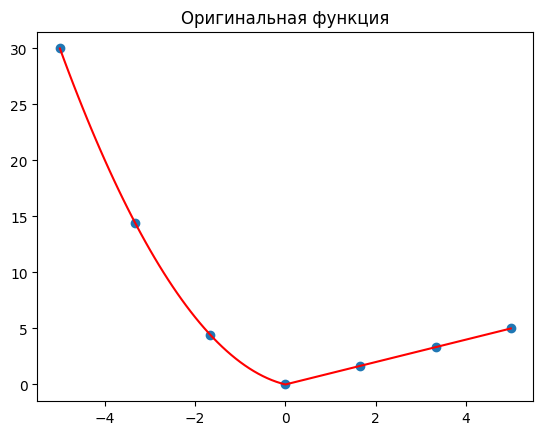

In [56]:
init(lambda x: x**2 * (x<0) + np.abs(x), -5, 5, 7)

plt.title('Оригинальная функция')
plt.plot(xSpace, func(xSpace), color='red')
plt.scatter(xRange, yRange)

plt.show()

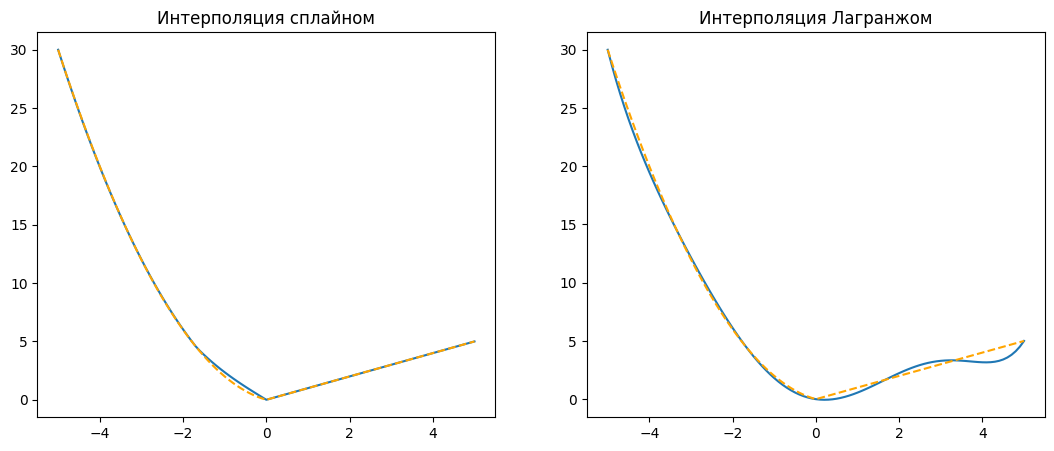

In [57]:
# Хитрым образом задаю моменты так, чтобы получить прямую, вместо гладкой кривой.
Moments = FindMoments4()
Moments[3:] = 0 # Обнуля в точке где начинается прямая, поскольку вторая производная (Чем и является момент) прямой равна нулю

absSpline = Spline(xSpace, Moments)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('Интерполяция сплайном')
ax[0].plot(xSpace, absSpline)
ax[0].plot(xSpace, func(xSpace), color='orange', linestyle='--')

Lagrange = sp.lambdify('x', LagrangeSym(xRange, yRange, h[0]) )
ax[1].set_title('Интерполяция Лагранжом')
ax[1].plot(xSpace, Lagrange(xSpace))
ax[1].plot(xSpace, func(xSpace), color='orange', linestyle='--')

### 2 Случай

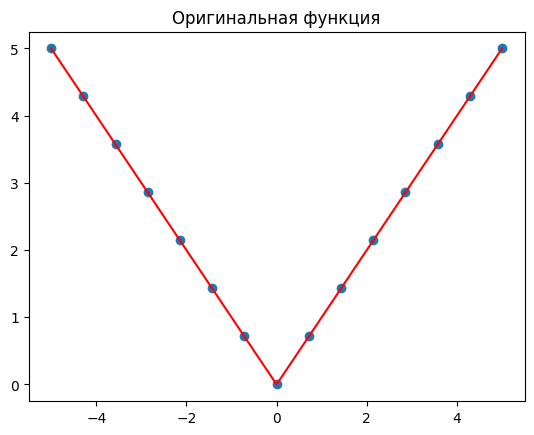

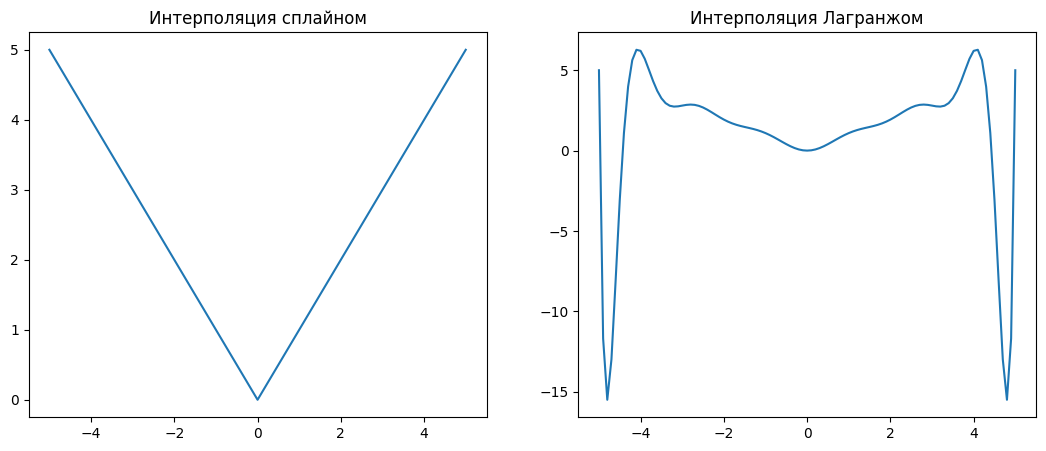

In [58]:
init( np.abs, -5, 5, 15)

plt.title('Оригинальная функция')
plt.plot(xSpace, func(xSpace), color='red')
plt.scatter(xRange, yRange)
plt.show()

Moments = np.zeros(points) # Сам задаю более точно моменты
absSpline = Spline(xSpace, Moments)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('Интерполяция сплайном')
ax[0].plot(xSpace, absSpline)

Lagrange = sp.lambdify('x', LagrangeSym(xRange, yRange, h[0]) )
ax[1].set_title('Интерполяция Лагранжом')
ax[1].plot(xSpace, Lagrange(xSpace))